In [1]:
import sys
from pathlib import Path

main_path = Path().absolute().parent
sys.path.append(str(main_path))

import seaborn as sns
import matplotlib.pyplot as plt

import shap
import numpy as np
import pandas as pd
from IPython.display import display

from fge import Dataset, ModelBuilder, TreeBuilder
shap.initjs()

In [2]:
seed = 8
dataset = Dataset(dataset_name='adult', data_folder='../data', seed=seed)
model_builder = ModelBuilder()
results = model_builder.train(dataset, eta=0.3, max_depth=8, subsample=1.0, seed=seed, num_rounds=200)

performance = results['score']
model = results['model']
print(f'test performance is {performance:.4f}')

tree_builder = TreeBuilder(model, dataset, original_score=performance)

[0]	test-logloss:0.53761
[40]	test-logloss:0.27630
[80]	test-logloss:0.28102
[120]	test-logloss:0.28647
[160]	test-logloss:0.29231
[199]	test-logloss:0.29741
test performance is 0.8674


In [3]:
group_id = None
shap_interactions = tree_builder.shap_interaction_values(group_id=group_id)

Getting Interaction Values via SHAP package, might take a while...
Processing: # of data = 29304, # of features = 12
Cost time: 1 mins 32.92 secs


In [9]:
# get tree from all train dataset
tree = tree_builder.build(
    score_method='abs_interaction', 
    shap_interactions=shap_interactions, 
    n_select_scores=10,
    n_select_performance=5, 
    max_iter=None,
    initialize='full',
    filter_method='sort',
    rt_only_best=False,
    verbose=False
)

Building Tree: 100%|██████████| 12/12 [00:12<00:00,  1.04s/it, N keys to run: 1] 


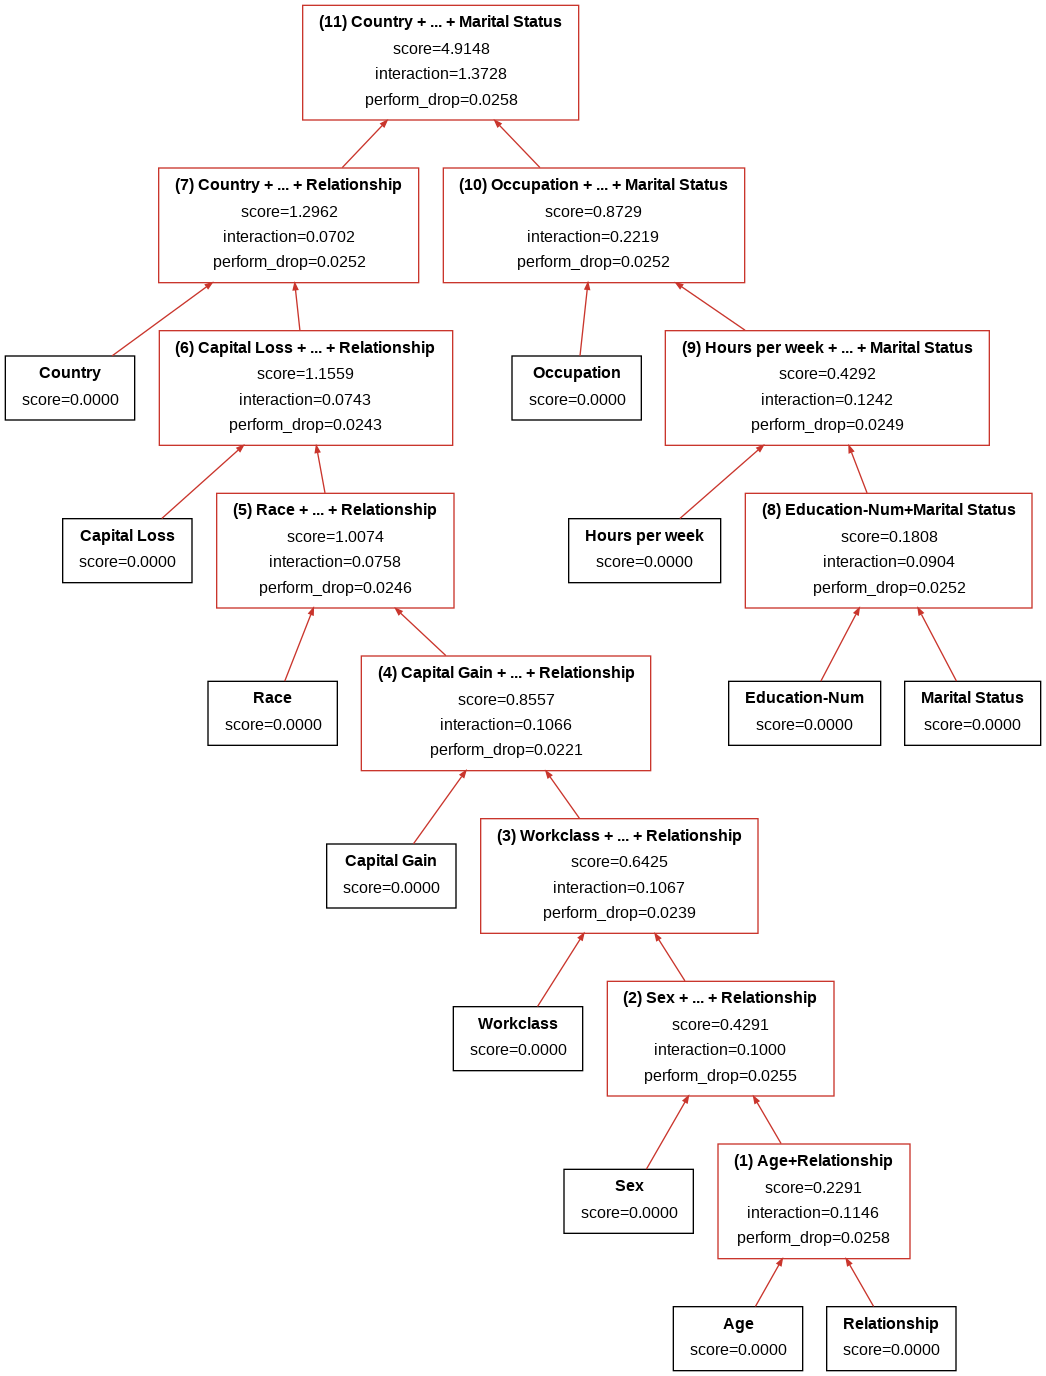

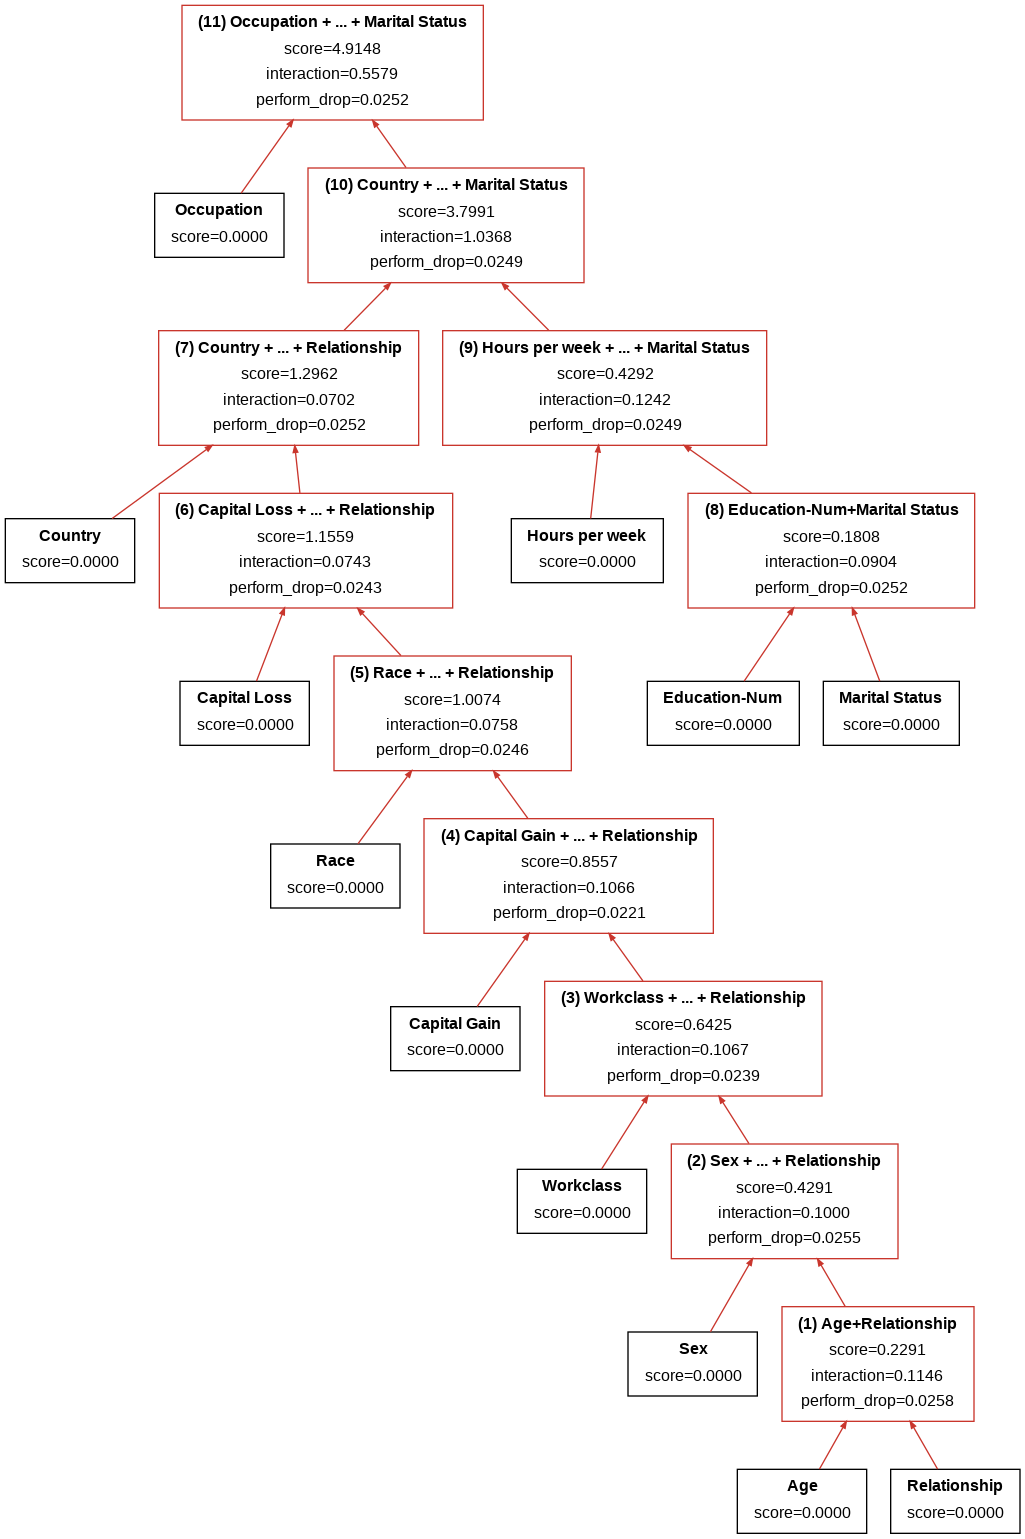

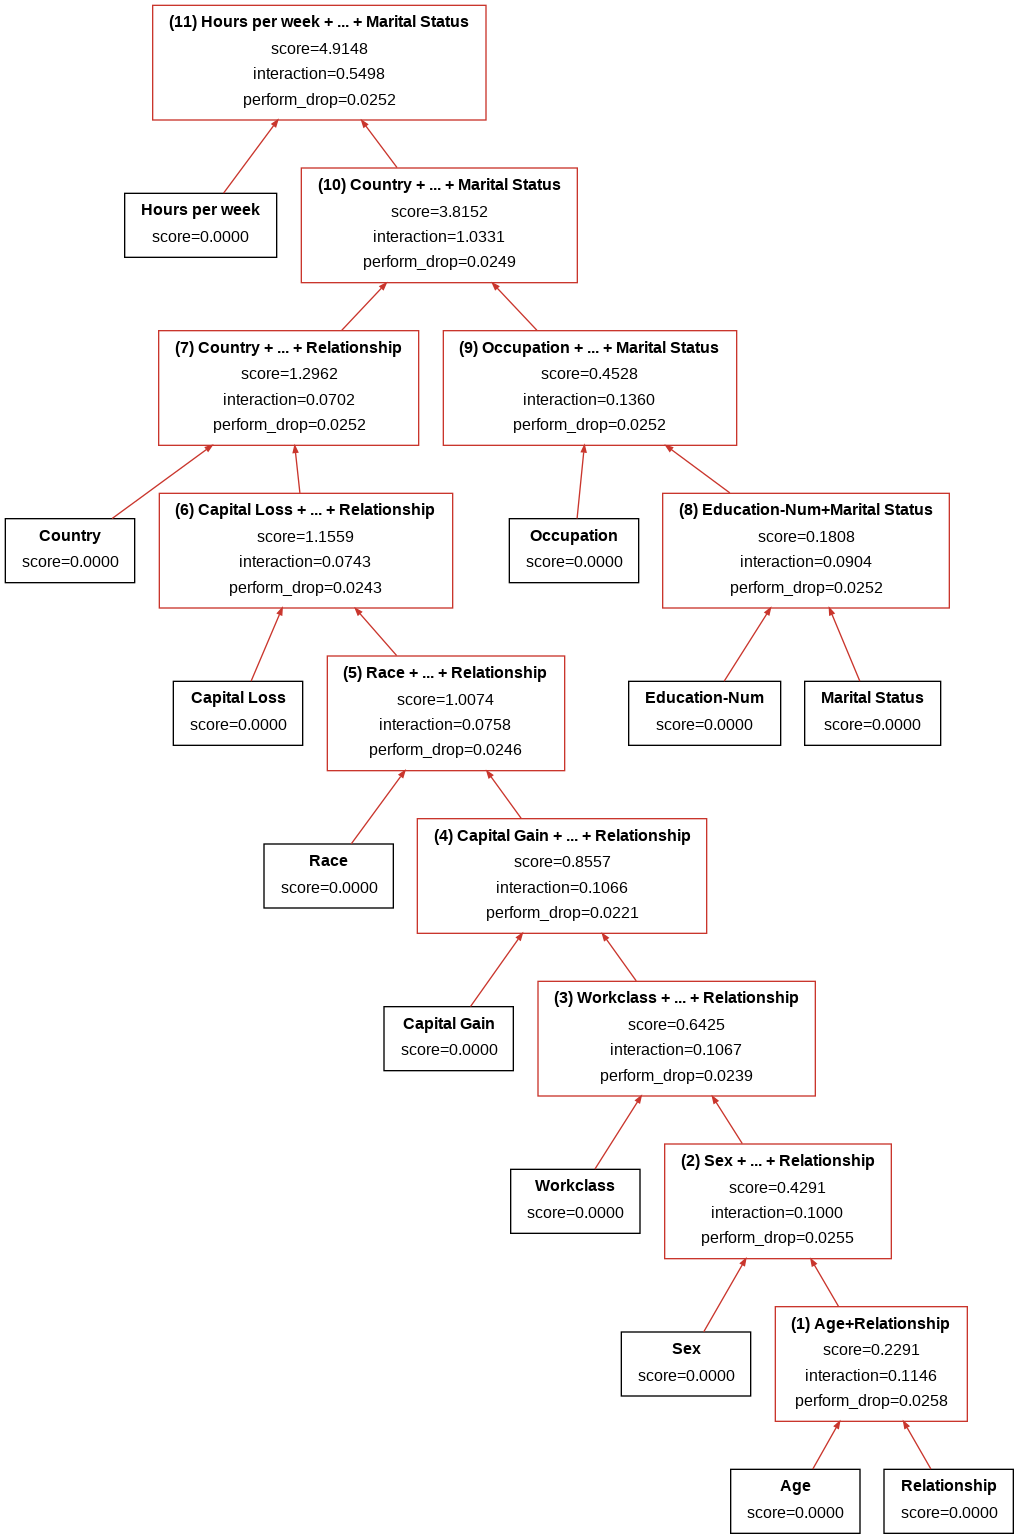

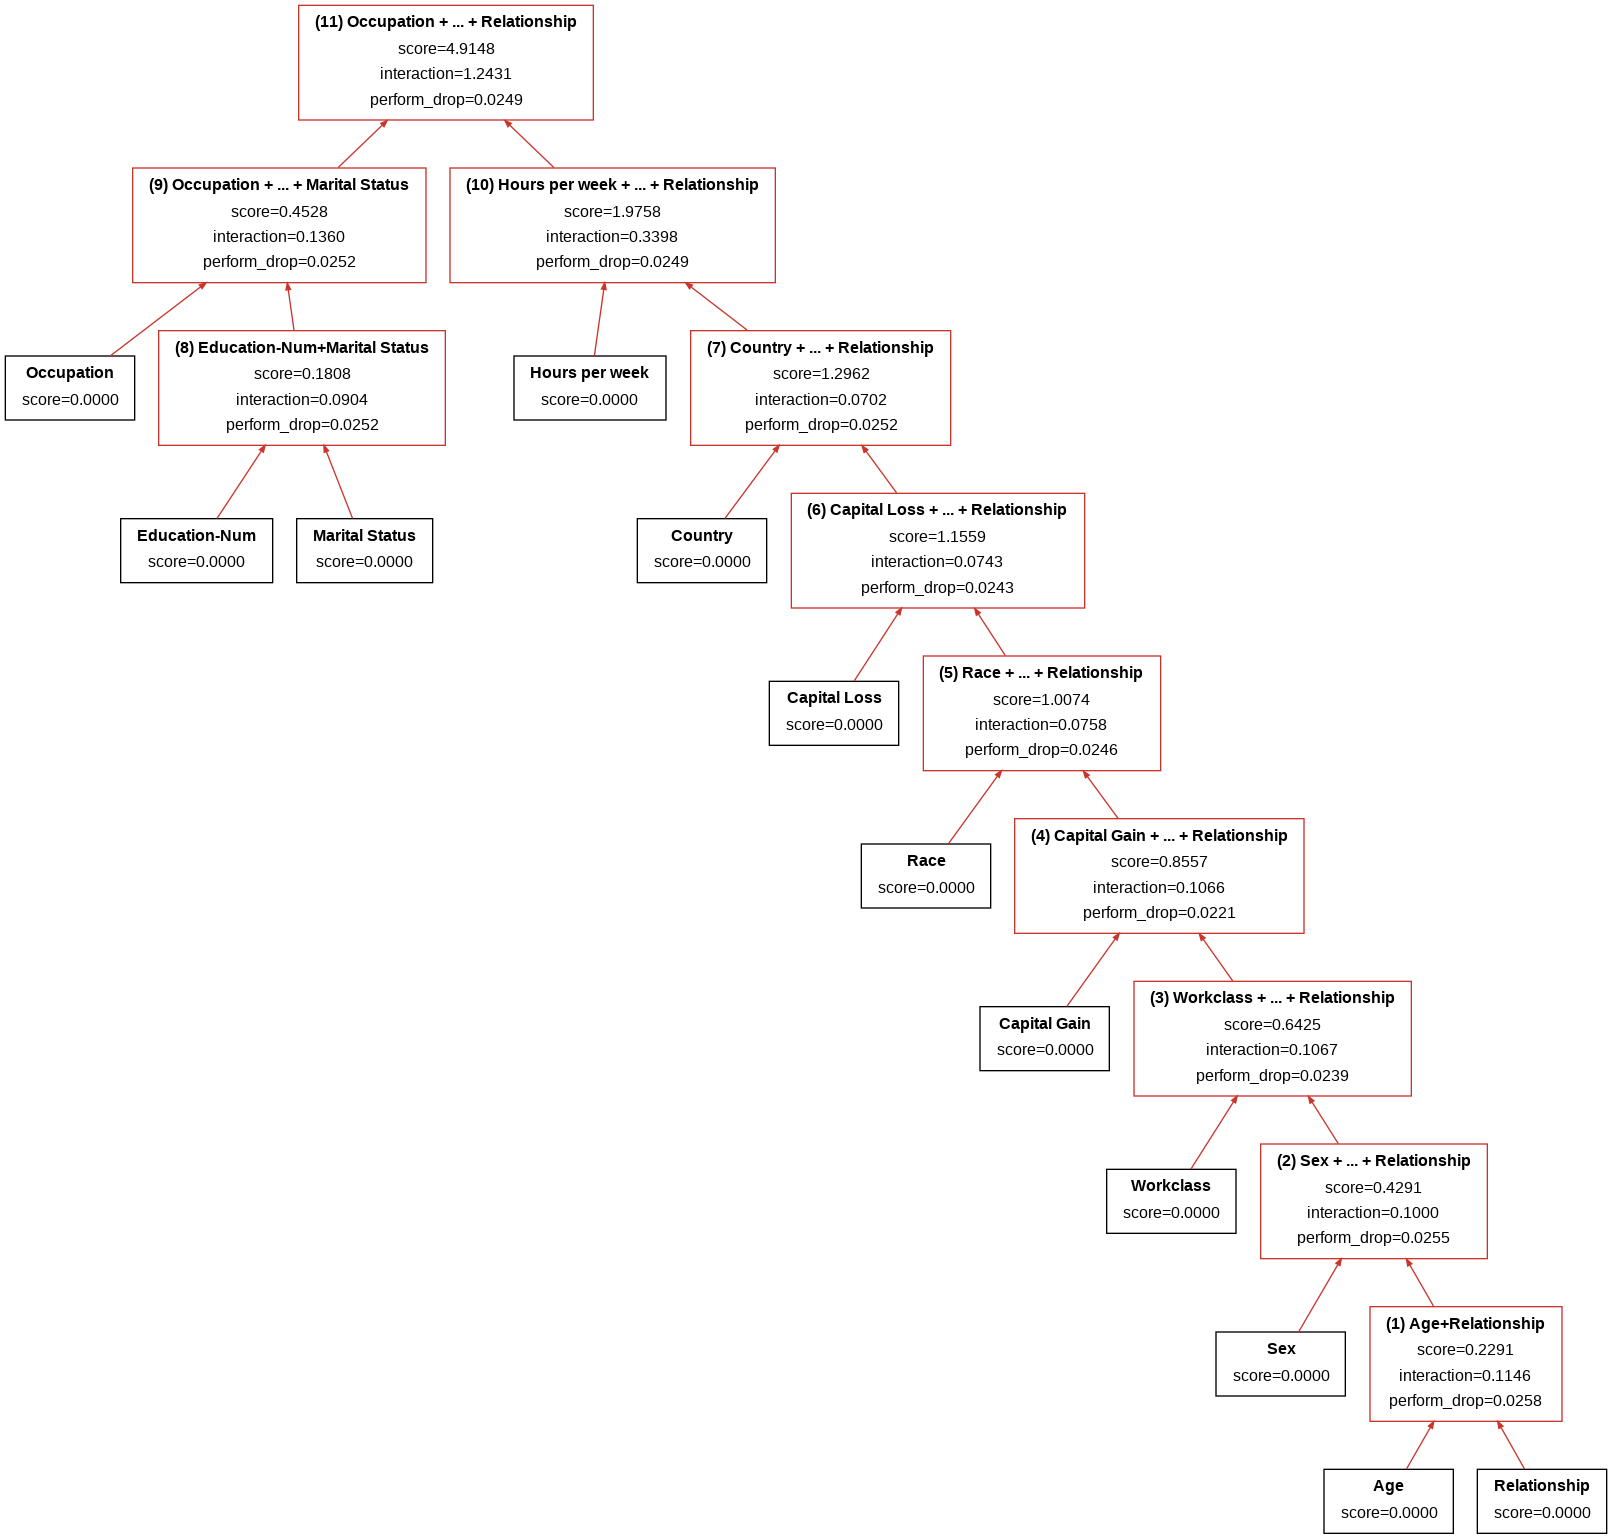

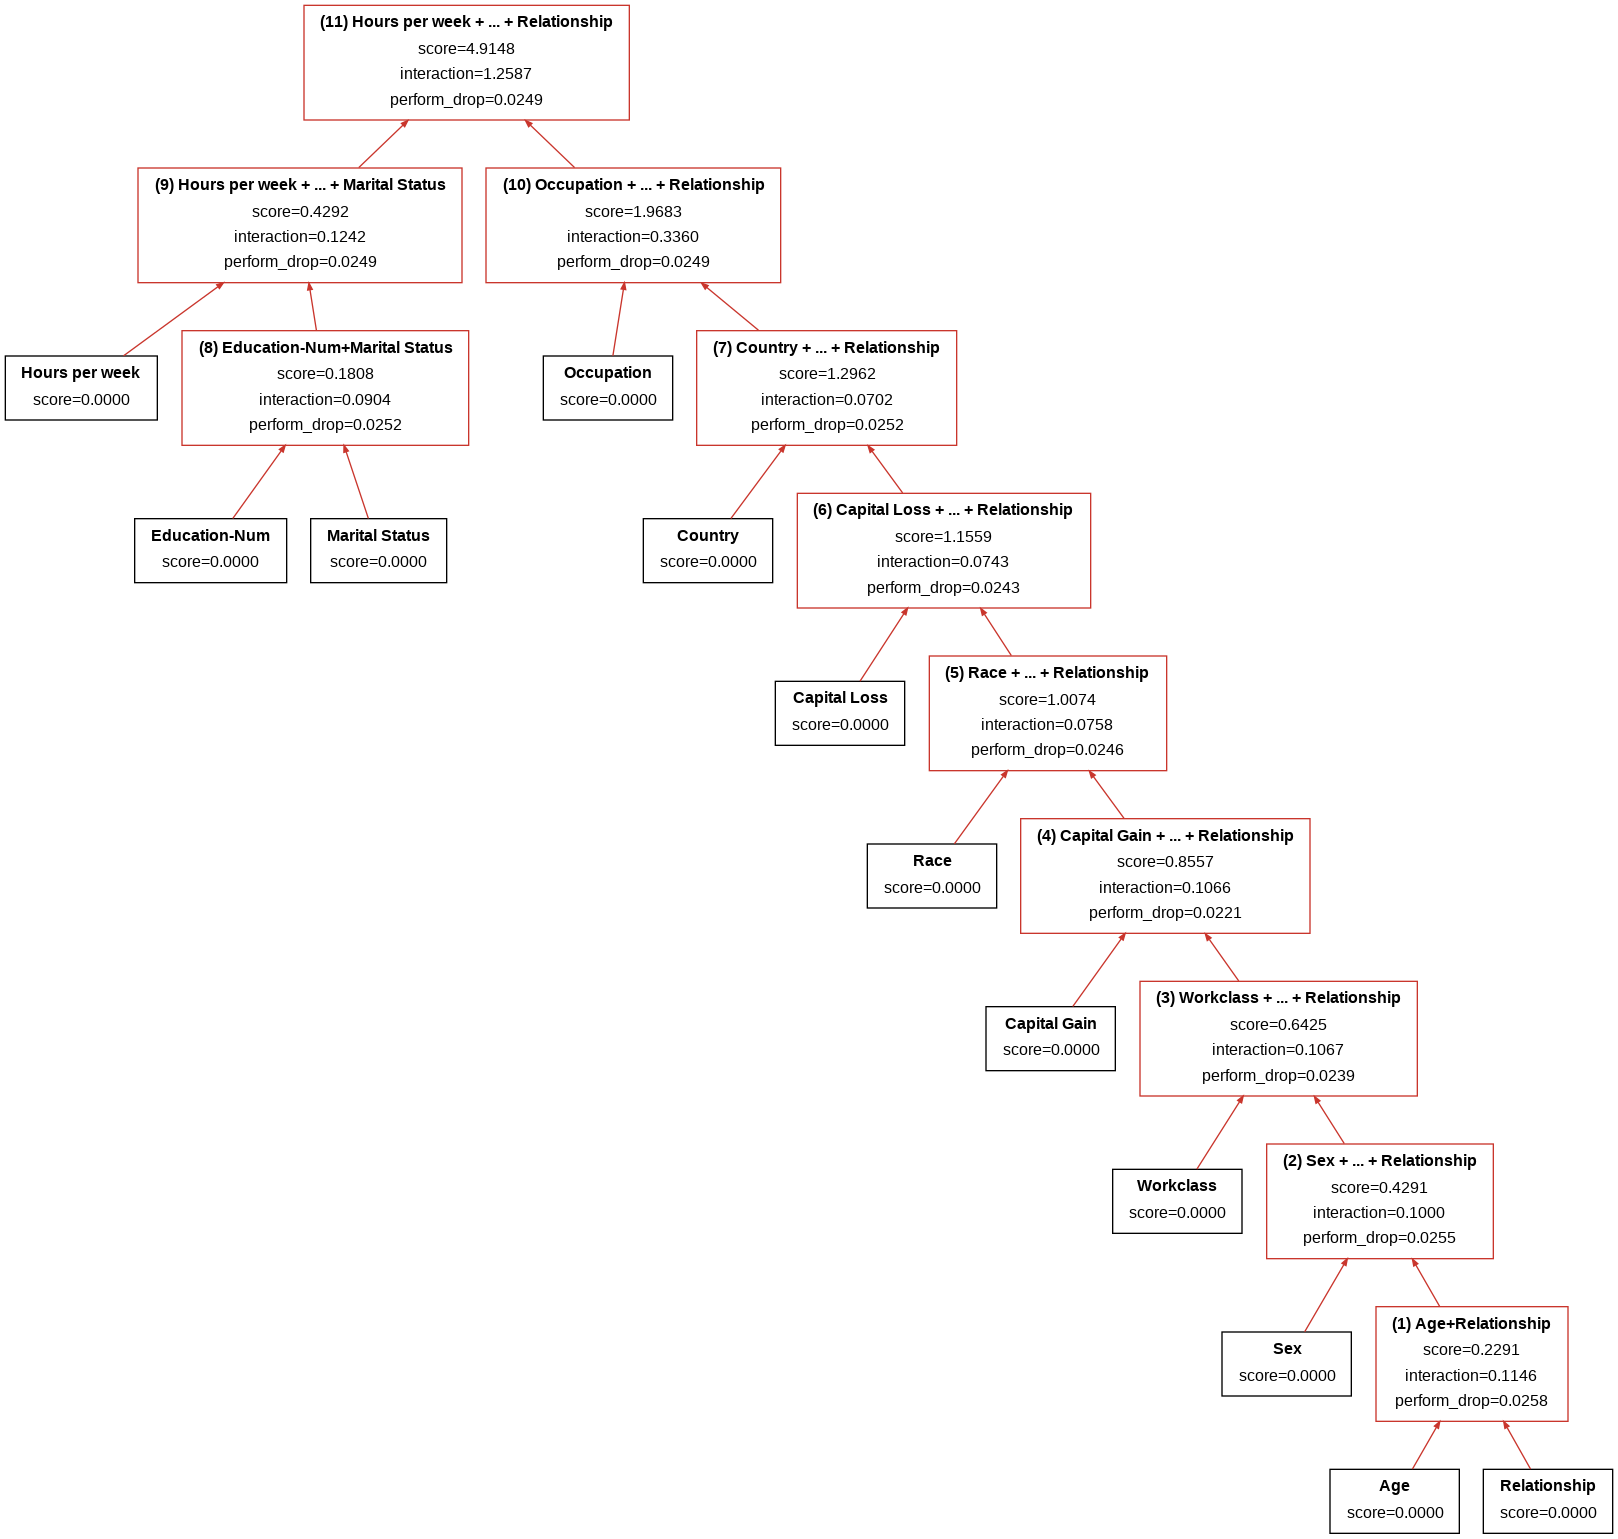

In [10]:
for t in tree:
    img = t.show_tree(dataset.feature_names)
    display(img)

---

## build tree algorithms

In [10]:
import numpy as np
import shap
import itertools
import time
import heapq
import random

from fge.functions import *
from fge.utils import flatten
from fge.fitter import PolyFitter
from fge.interaction_tree import ShapInteractionTree

from typing import Dict, Any
from copy import deepcopy
from collections import defaultdict
from tqdm import tqdm
from anytree import Node

In [11]:
score_method='abs'
shap_interactions=shap_interactions
n_select_scores=5
n_select_performance=5
max_iter=None
initialize='random'
rt_only_best=False
verbose=False

In [12]:
k = 0
siv_scores = tree_builder.score_methods['abs'](shap_interactions, build_global=True)
feature_names = np.arange(shap_interactions.shape[-1])
r_diag, c_diag = np.diag_indices(len(feature_names))
main_effect = siv_scores[r_diag, c_diag]
infos = defaultdict(dict)
n_features = siv_scores.shape[1]

infos[k]['nodes'] = [dict()]
infos[k]['done'] = [set()]
for i, name in enumerate(feature_names):
    infos[k]['nodes'][0][i] = Node(
        name=name, parent=None, score=main_effect[i], interaction=0.0, k=0, drop=0.0
    )


# n_filter = 1 if len(nodes_to_run)*r_filter < 0 else int(len(nodes_to_run)*r_filter)
if initialize == 'random':
    filtered_nodes_to_run = list(np.random.choice(feature_names, size=(n_select_scores,), replace=False))
elif initialize == 'sort':
    nodes_to_run = [(key, n.score) for key, n in infos[k]['nodes'][0].items() if key not in infos[k]['done'][0]]
    sorted_nodes_to_run = sorted(nodes_to_run, key=lambda x: x[1], reverse=True)
    filtered_nodes_to_run = list(map(lambda x: x[0], sorted_nodes_to_run[:n_select_scores]))
else:
    filtered_nodes_to_run = list(feature_names)

# infos[k]['scores'] = [{n: infos[k]['nodes'][0][n] for n in filtered_nodes_to_run}]
infos[k]['nodes_to_run'] = [filtered_nodes_to_run]
infos[k]['performance'] = tree_builder.polyfitter.original_score

In [13]:
tree_builder.infos[9]['nodes'][-1].keys()

dict_keys([(4, (1, 5)), (9, (0, 3)), ((6, (10, 11)), (2, (7, 8)))])

In [28]:
k = 4
siv_scores = tree_builder.score_methods['abs'](shap_interactions, build_global=True)
feature_names = np.arange(shap_interactions.shape[-1])
infos = deepcopy(tree_builder.infos)

In [29]:
k += 1

In [30]:
performances = []
heapq.heapify(performances)
i = 0

In [38]:
prev_nodes_to_run = deepcopy(infos[k-1]['nodes_to_run'])
prev_nodes = deepcopy(infos[k-1]['nodes'])

In [32]:
prev_nodes_to_run

[[1, 2, 4, 5, 9, (7, 8), (0, 3), (6, (10, 11))],
 [4, 5, 6, 9, (7, 8), (10, 11), (0, 3), (1, 2)],
 [1, 2, 4, 5, 9, (7, 8), (10, 11), (6, (0, 3))],
 [1, 2, 5, 9, (7, 8), (10, 11), (0, 3), (4, 6)],
 [1, 2, 4, 5, 6, (7, 8), (0, 3), (9, (10, 11))]]

In [33]:
infos[k]['nodes'] = []
infos[k]['nodes_to_run'] = []
infos[k]['performance'] = []

In [34]:
def filter_scores(scores, n_select_scores, existed_cmbs=None):
    if len(scores) == 1:
        return list(scores.keys())
    if existed_cmbs is not None:
        filtered = [key for key in scores.keys() if str(key) not in existed_cmbs]
    else:
        filtered = list(scores.keys())

    dup = set()
    n = 0
    filtered = []
    while (n < n_select_scores) and (len(dup) < len(scores)):
        c = random.choice(list(scores.keys()))
        if c in dup:
            continue
        else:
            dup.add(c)
            filtered.append(c)
        n += 1
    # filtered = list(np.random.choice(filtered, size=(n_select_scores,), replace=False))
    return filtered

def get_scores(siv_scores, nodes_to_run):
    scores = {}
    for cs in itertools.combinations(nodes_to_run, 2):
        if cs not in scores.keys():
            r, c = list(zip(*itertools.product(flatten(cs), flatten(cs))))
            scores[cs] = siv_scores[r, c].sum()
    return scores

In [35]:
for nodes_to_run, nodes in zip(prev_nodes_to_run, prev_nodes):
    # existed_cmbs = list(map(lambda x: str(x), filter(lambda x: isinstance(x, tuple), nodes.keys())))
    scores = tree_builder.get_scores(siv_scores, nodes_to_run)
    filtered_keys = filter_scores(scores, n_select_scores)
    print(len(filtered_keys))
    print(filtered_keys)

5
[(4, (7, 8)), ((0, 3), (6, (10, 11))), (2, 9), (1, 4), (2, 4)]
5
[(6, (10, 11)), (5, (10, 11)), (5, (1, 2)), ((7, 8), (0, 3)), ((10, 11), (0, 3))]
5
[(4, 9), (1, 5), (2, 9), (2, (6, (0, 3))), (9, (7, 8))]
5
[((10, 11), (0, 3)), (1, 9), (9, (10, 11)), (9, (4, 6)), (5, (0, 3))]
5
[(1, (0, 3)), (2, 6), (2, 4), (2, 5), (5, (0, 3))]


In [39]:
nodes_to_run = prev_nodes_to_run.pop(0)
nodes = prev_nodes.pop(0)
scores = tree_builder.get_scores(siv_scores, nodes_to_run)
filtered_keys = tree_builder.filter_scores(scores, n_select_scores)

In [105]:
for cmbs in filtered_keys:
    i += 1
    trials = list(nodes.keys()) + [cmbs]
    performance = tree_builder.polyfitter.fit_selected(trials)
    performance_drop = infos[0]['performance'] - performance
    if len(performances) >= n_select_performance:
        if performances[0][1] > performance_drop:
            heapq.heappushpop(performances, (-n_select_performance, performance_drop, cmbs, deepcopy(nodes), deepcopy(done)))
    else:
        heapq.heappush(performances, (-i, performance_drop, cmbs, deepcopy(nodes), deepcopy(done)))

In [106]:
for x in performances:
    print(x[:3])

(-5, 0.024562480810561893, (2, 10))
(-4, 0.024562480810561893, (2, 11))
(-2, 0.024255449800429818, (5, 8))
(-1, 0.024562480810561893, (0, 11))
(-3, 0.024562480810561893, (10, 11))


In [107]:
for _, p, cmbs, nodes, done in performances:
    value, interaction = tree_builder.get_value_and_interaction(siv_scores, cmbs)
    feature_name = '+'.join([str(tree_builder.feature_names[i]) for i in flatten(cmbs)])     
    children = [nodes[c] for c in cmbs]
    nodes[cmbs] = Node(
        name=feature_name, 
        score=value, 
        interaction=interaction, 
        children=children, 
        k=k,
        drop=0.0
    )
    nodes[cmbs].drop = p

    # add impossibles cmbs
    for c in cmbs:
        done.add(c)
        nodes.pop(c)
    infos[k]['done'].append(done)
    infos[k]['performance'].append(p)
    infos[k]['nodes'].append(nodes)
    new_nodes_to_run = [k for k in nodes.keys() if k not in done]
    infos[k]['nodes_to_run'].append(new_nodes_to_run)

In [111]:
infos[2]['done']

[{1, 2, 9, 10}, {1, 2, 9, 11}, {1, 5, 8, 9}, {0, 1, 9, 11}, {1, 9, 10, 11}]

In [113]:
infos[2]['nodes'][0].keys()

dict_keys([0, 3, 4, 5, 6, 7, 8, 11, (1, 9), (2, 10)])

---

## Group with labels equals to 0

In [20]:
# get tree from group 0
group_id = 0
shap_interactions_g0 = tree_builder.shap_interaction_values(group_id=group_id)

Getting Interaction Values via SHAP package, might take a while...
Processing: # of data = 22230, # of features = 12
Cost time: 1 mins 10.51 secs


In [21]:
tree = tree_builder.build(
    score_method='abs_interaction', 
    shap_interactions=shap_interactions_g0, 
    n_select_scores=10,
    n_select_performance=5, 
    max_iter=None,
    initialize='full',
    filter_method='sort',
    rt_only_best=True
)
img = tree.show_tree(feature_names=dataset.feature_names)

Building Tree: 100%|██████████| 12/12 [00:14<00:00,  1.17s/it, N keys to run: 1]


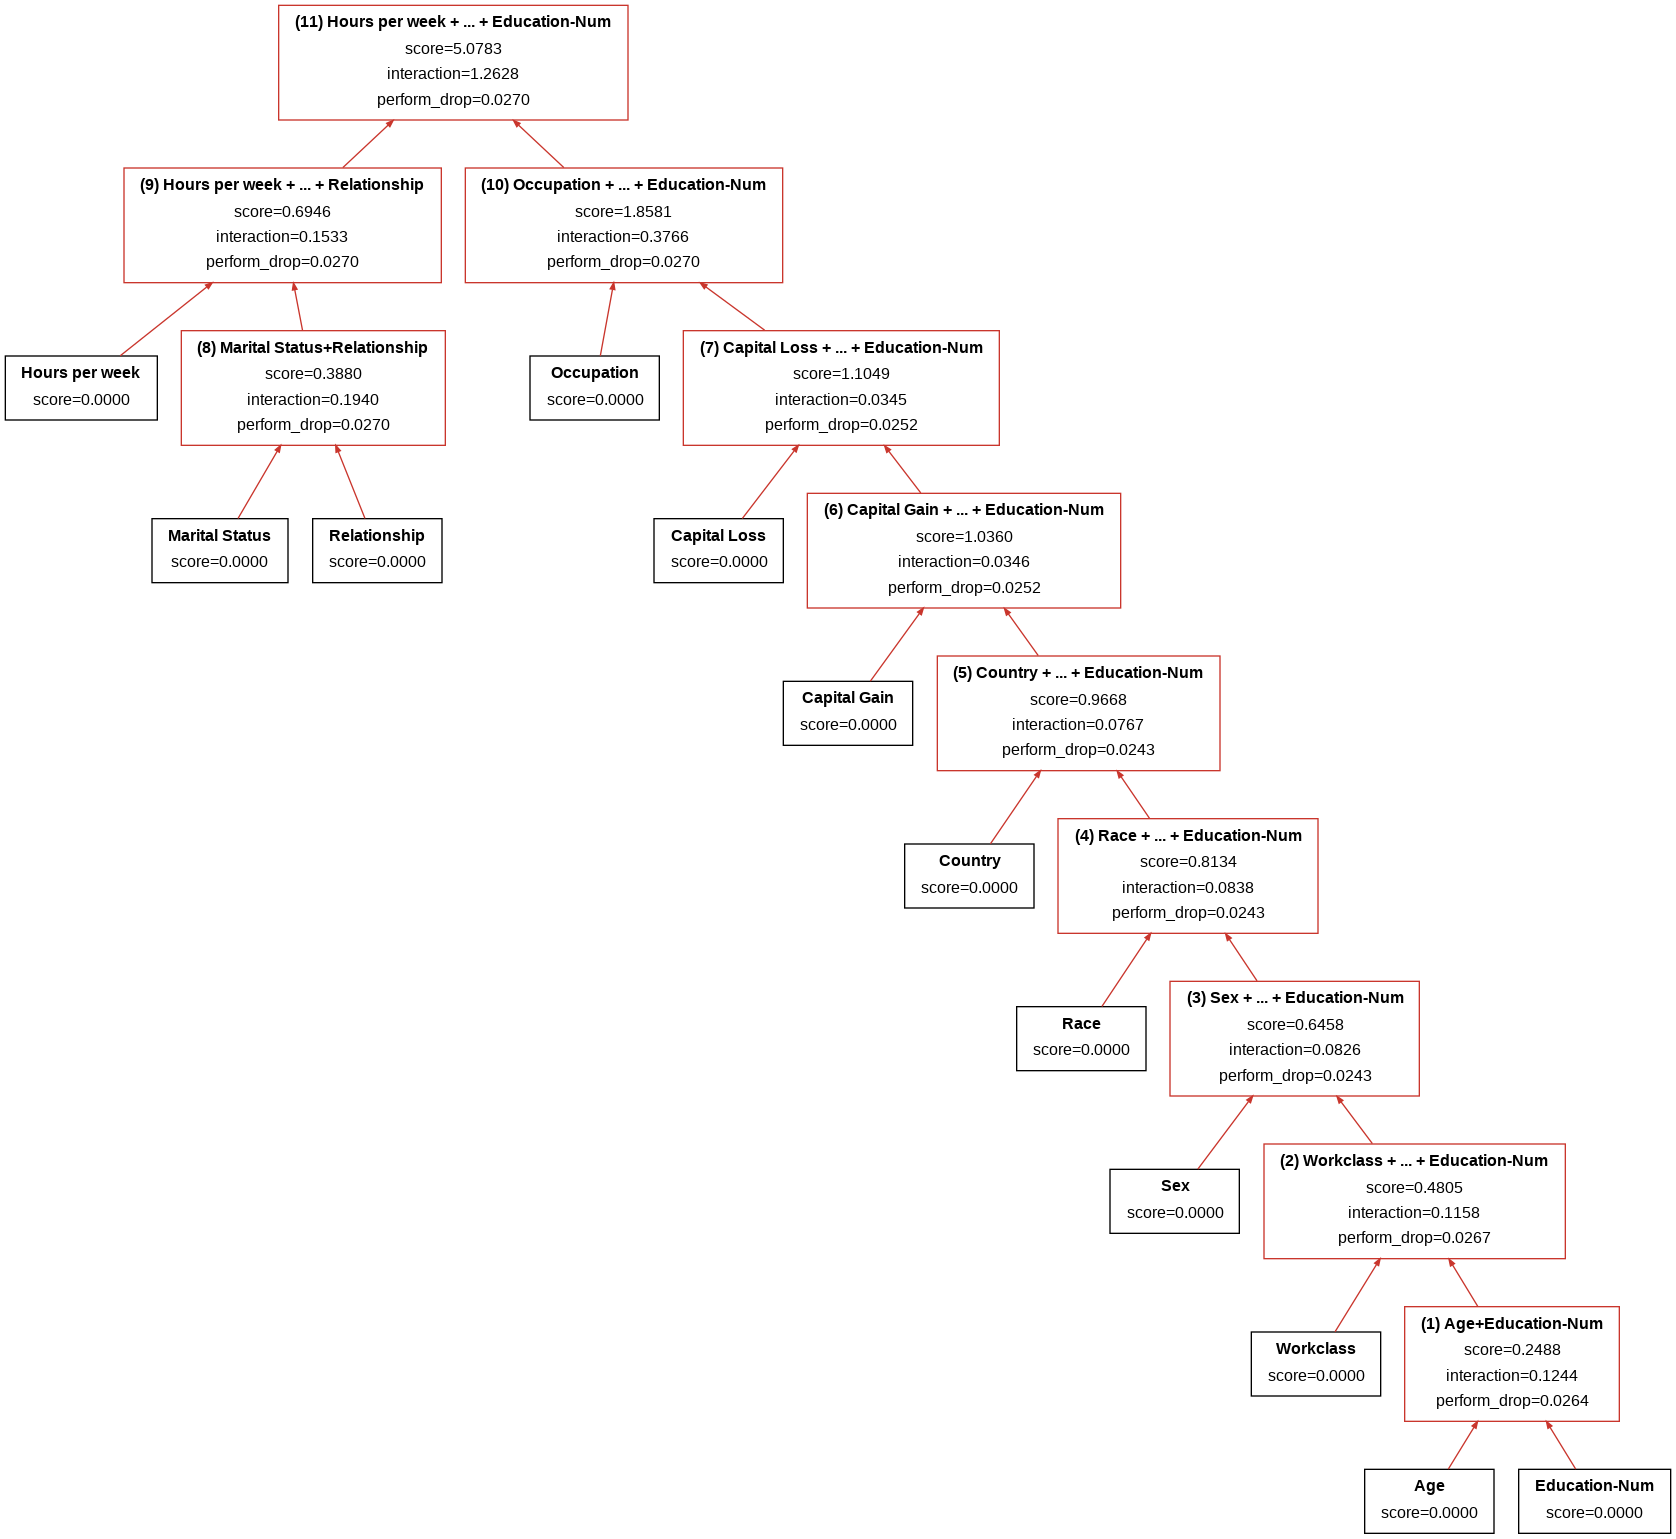

In [22]:
display(img)

## Group with labels equals to 1

In [23]:
# get tree from group 0
group_id = 1
shap_interactions_g1 = tree_builder.shap_interaction_values(group_id=group_id)

Getting Interaction Values via SHAP package, might take a while...
Processing: # of data = 7074, # of features = 12
Cost time: 0 mins 22.86 secs


In [24]:
tree = tree_builder.build(
    score_method='abs_interaction', 
    shap_interactions=shap_interactions_g1, 
    n_select_scores=10,
    n_select_performance=5, 
    max_iter=None,
    initialize='full',
    filter_method='sort',
    rt_only_best=True
)
img = tree.show_tree(feature_names=dataset.feature_names)

Building Tree: 100%|██████████| 12/12 [00:12<00:00,  1.02s/it, N keys to run: 1] 


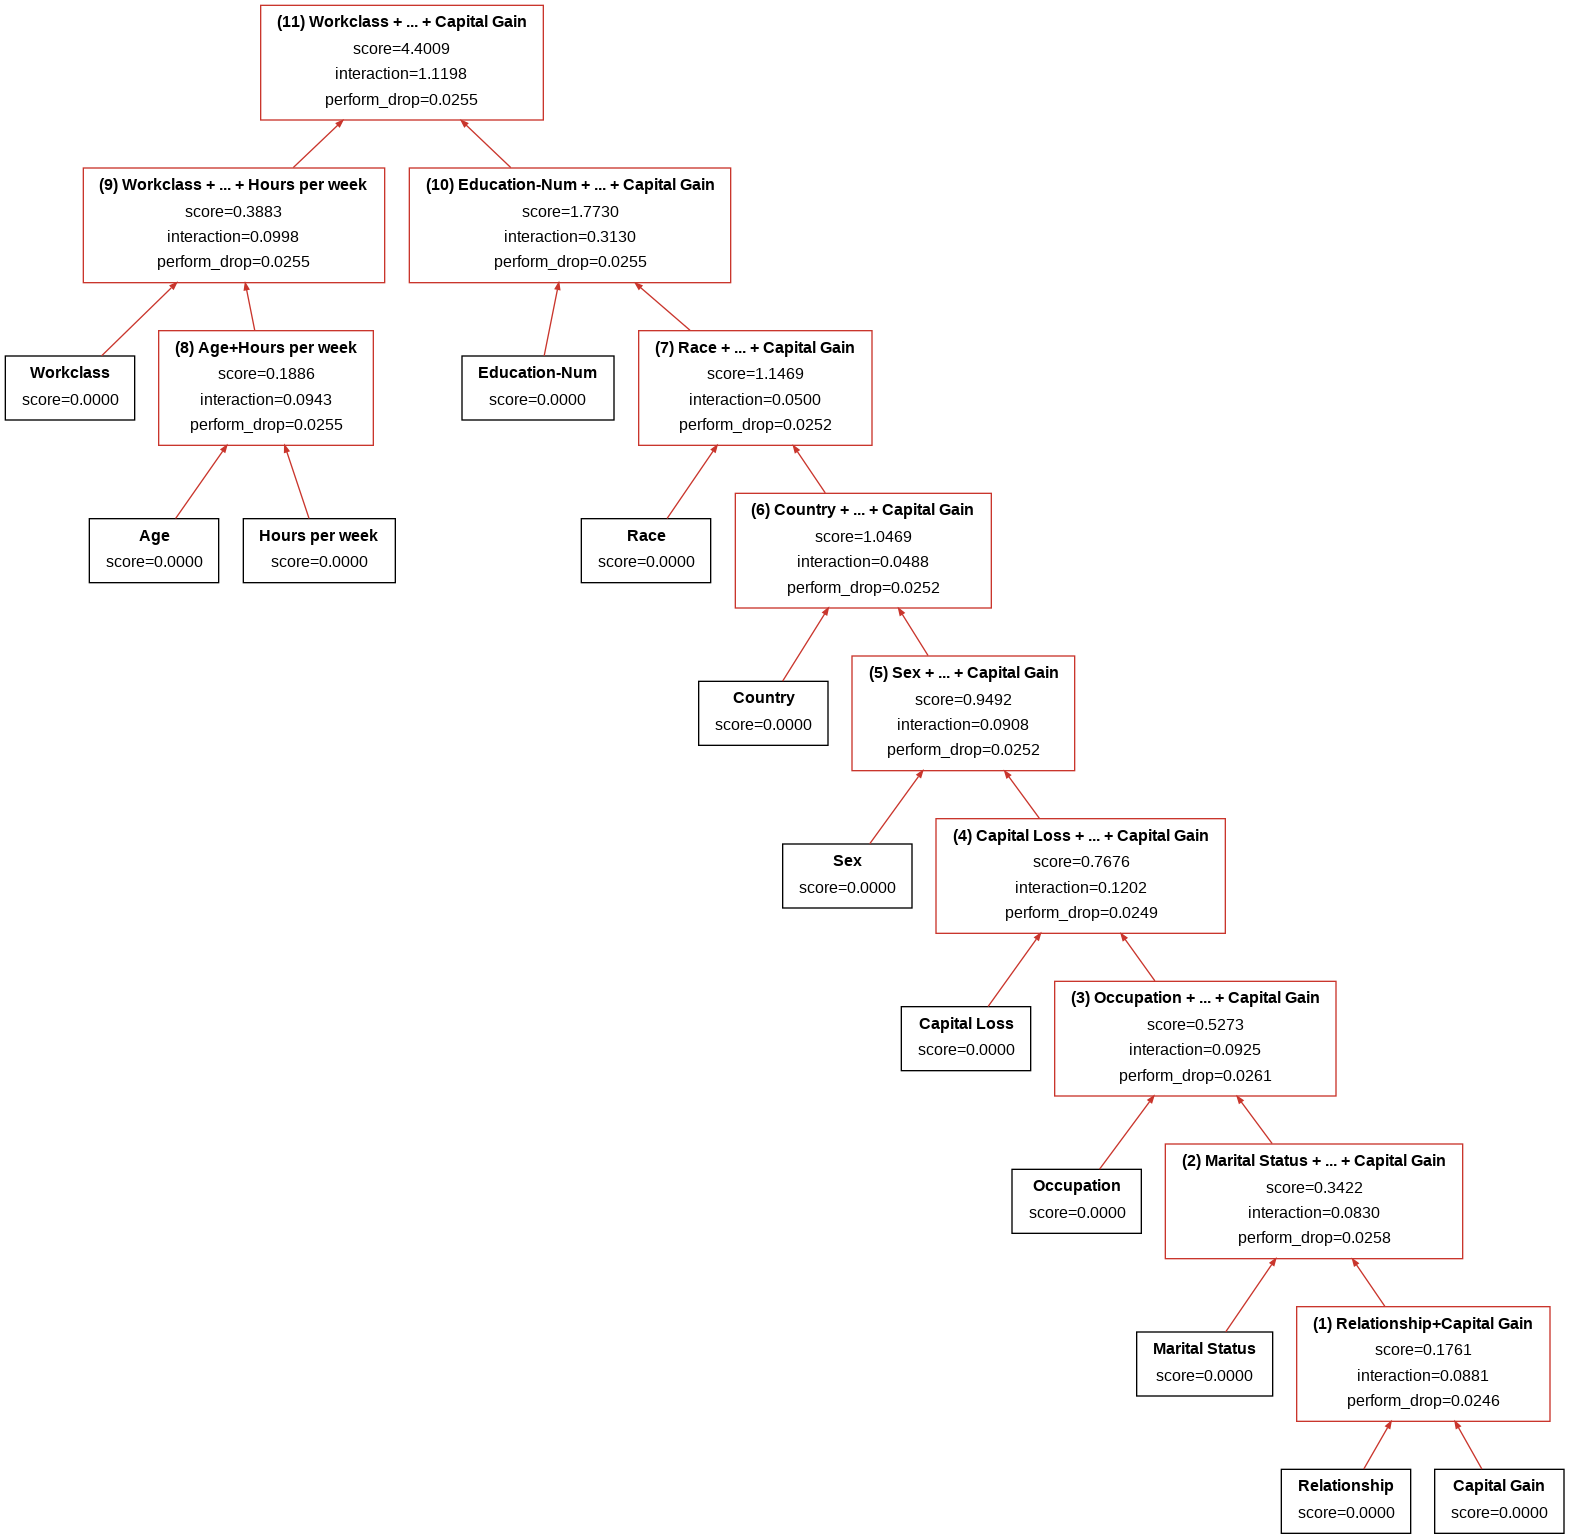

In [25]:
display(img)

# California

In [26]:
seed = 8
dataset = Dataset(dataset_name='california', data_folder='../data', seed=seed)
model_builder = ModelBuilder()
results = model_builder.train(dataset, eta=0.3, max_depth=8, subsample=1.0, seed=seed, num_rounds=200)

performance = results['score']
model = results['model']
print(f'test performance is {performance:.4f}')

tree_builder = TreeBuilder(model, dataset, original_score=performance)

[0]	test-rmse:1.43881
[40]	test-rmse:0.46441
[80]	test-rmse:0.45844
[120]	test-rmse:0.45695
[160]	test-rmse:0.45652
[199]	test-rmse:0.45819
test performance is 0.8453


In [35]:
# get tree from group 0
group_id = 0
shap_interactions_g0 = tree_builder.shap_interaction_values(group_id=group_id)

Getting Interaction Values via SHAP package, might take a while...
Processing: # of data = 4637, # of features = 8
Cost time: 0 mins 20.71 secs


In [37]:
tree = tree_builder.build(
    score_method='abs', 
    shap_interactions=shap_interactions_g0, 
    n_select_scores=10,
    n_select_performance=5, 
    max_iter=None,
    initialize='sort',
    filter_method='random',
    rt_only_best=True
)
img = tree.show_tree(feature_names=dataset.feature_names)

Building Tree: 100%|██████████| 8/8 [00:01<00:00,  4.05it/s, N keys to run: 1]


<AxesSubplot:ylabel='Count'>

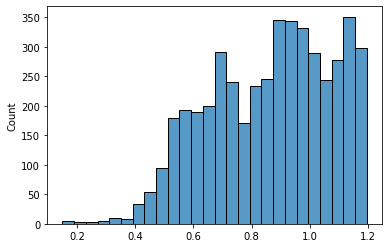

In [38]:
sns.histplot(dataset[group_id]['y_train'])

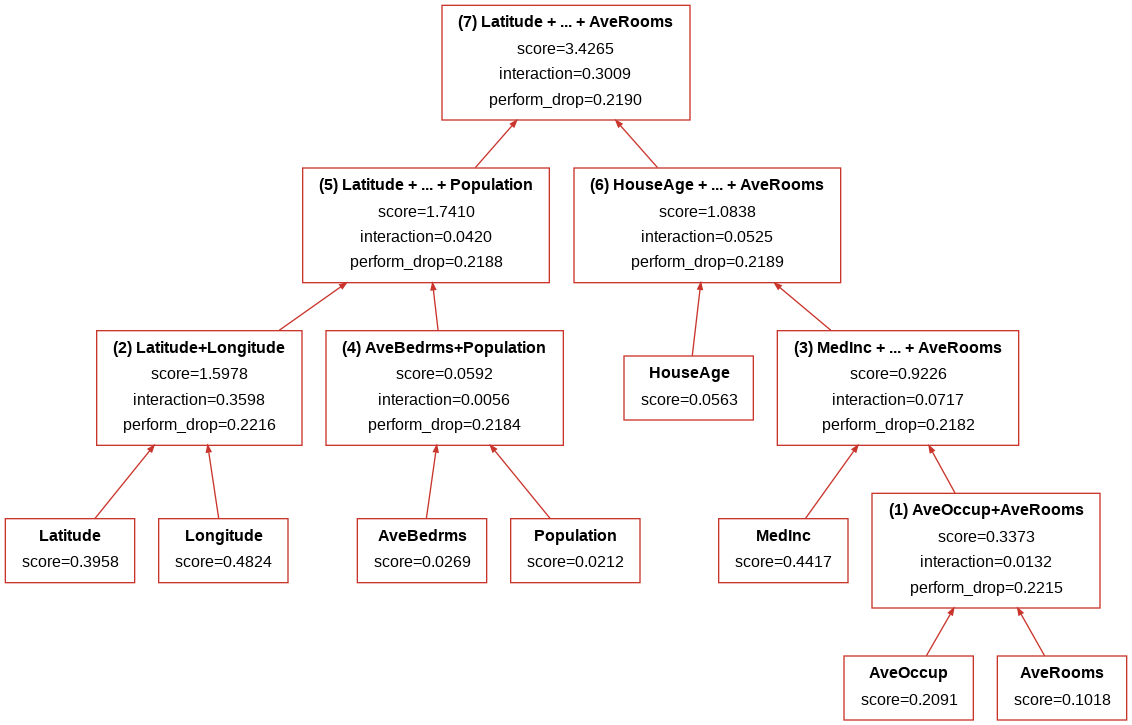

In [39]:
display(img)

In [40]:
# get tree from group 3
group_id = 3
shap_interactions_g3 = tree_builder.shap_interaction_values(group_id=group_id)

Getting Interaction Values via SHAP package, might take a while...
Processing: # of data = 3762, # of features = 8
Cost time: 0 mins 17.17 secs


In [45]:
tree = tree_builder.build(
    score_method='abs', 
    shap_interactions=shap_interactions_g3, 
    n_select_scores=10,
    n_select_performance=5, 
    max_iter=None,
    initialize='sort',
    filter_method='random',
    rt_only_best=True
)
img = tree.show_tree(feature_names=dataset.feature_names)

Building Tree: 100%|██████████| 8/8 [00:01<00:00,  5.05it/s, N keys to run: 1]  


<AxesSubplot:ylabel='Count'>

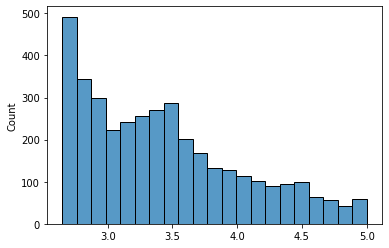

In [46]:
sns.histplot(dataset[group_id]['y_train'])

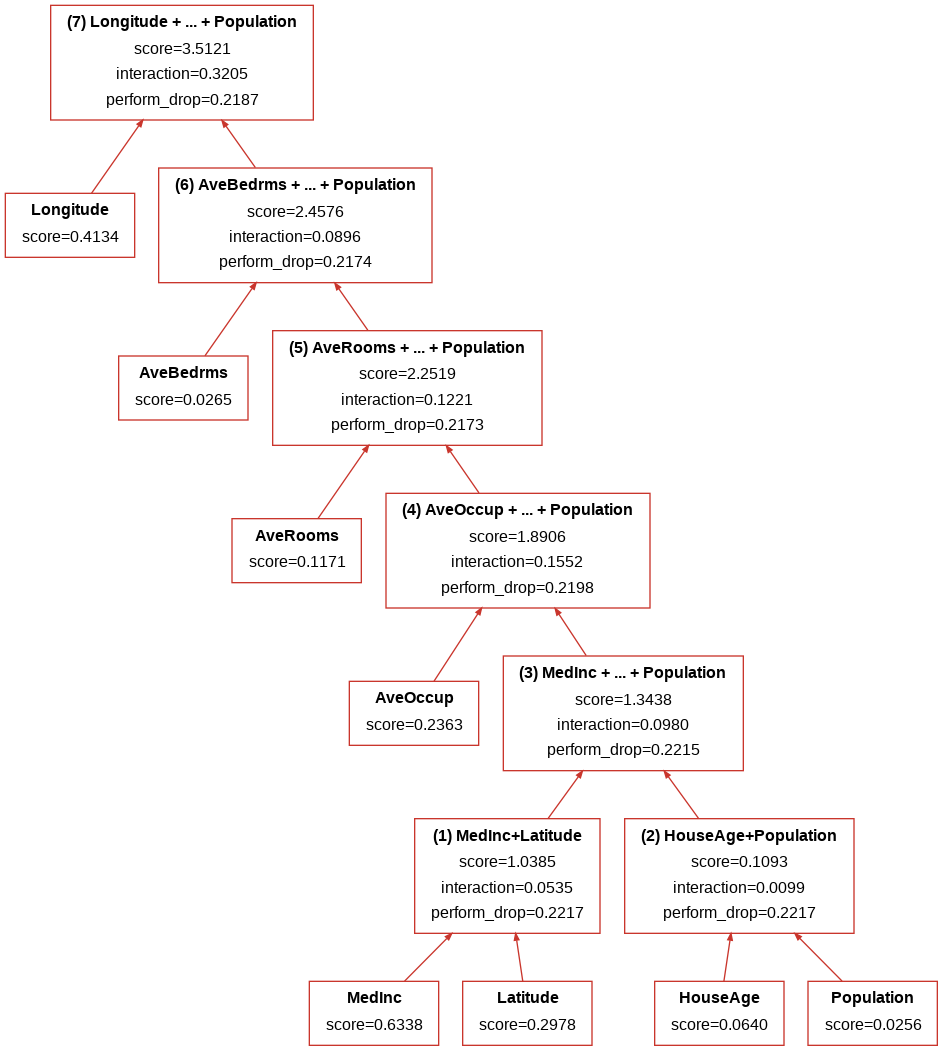

In [47]:
display(img)

# Boston

In [48]:
seed = 8
dataset = Dataset(dataset_name='boston', data_folder='../data', seed=seed)
model_builder = ModelBuilder()
results = model_builder.train(dataset, eta=0.1, max_depth=8, subsample=1.0, seed=seed, num_rounds=200)

performance = results['score']
model = results['model']
print(f'test performance is {performance:.4f}')

tree_builder = TreeBuilder(model, dataset, original_score=performance)

[0]	test-rmse:22.06412
[40]	test-rmse:4.58470
[80]	test-rmse:4.58613
[120]	test-rmse:4.57404
[160]	test-rmse:4.57352


Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :func:`~sklearn.datasets.fetch_california_housing`) and the Ames housing
    datase

[199]	test-rmse:4.57308
test performance is 0.7719


* CRIM - per capita crime rate by town
* ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
* INDUS - proportion of non-retail business acres per town.
* CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
* NOX - nitric oxides concentration (parts per 10 million)
* RM - average number of rooms per dwelling
* AGE - proportion of owner-occupied units built prior to 1940
* DIS - weighted distances to five Boston employment centres
* RAD - index of accessibility to radial highways
* TAX - full-value property-tax rate per $10,000
* PTRATIO - pupil-teacher ratio by town
* B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
* LSTAT - % lower status of the population
* MEDV - Median value of owner-occupied homes in $1000's

In [49]:
# get tree from group 0
group_id = 0
shap_interactions_g0 = tree_builder.shap_interaction_values(group_id=group_id)

Getting Interaction Values via SHAP package, might take a while...
Processing: # of data = 113, # of features = 13
Cost time: 0 mins 0.54 secs


<AxesSubplot:ylabel='Count'>

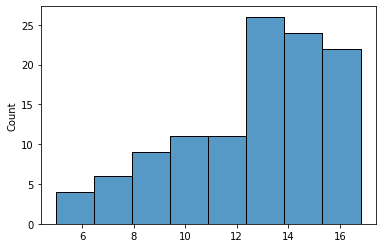

In [50]:
sns.histplot(dataset[group_id]['y_train'])

Building Tree: 100%|██████████| 13/13 [00:00<00:00, 23.15it/s, N keys to run: 1]  


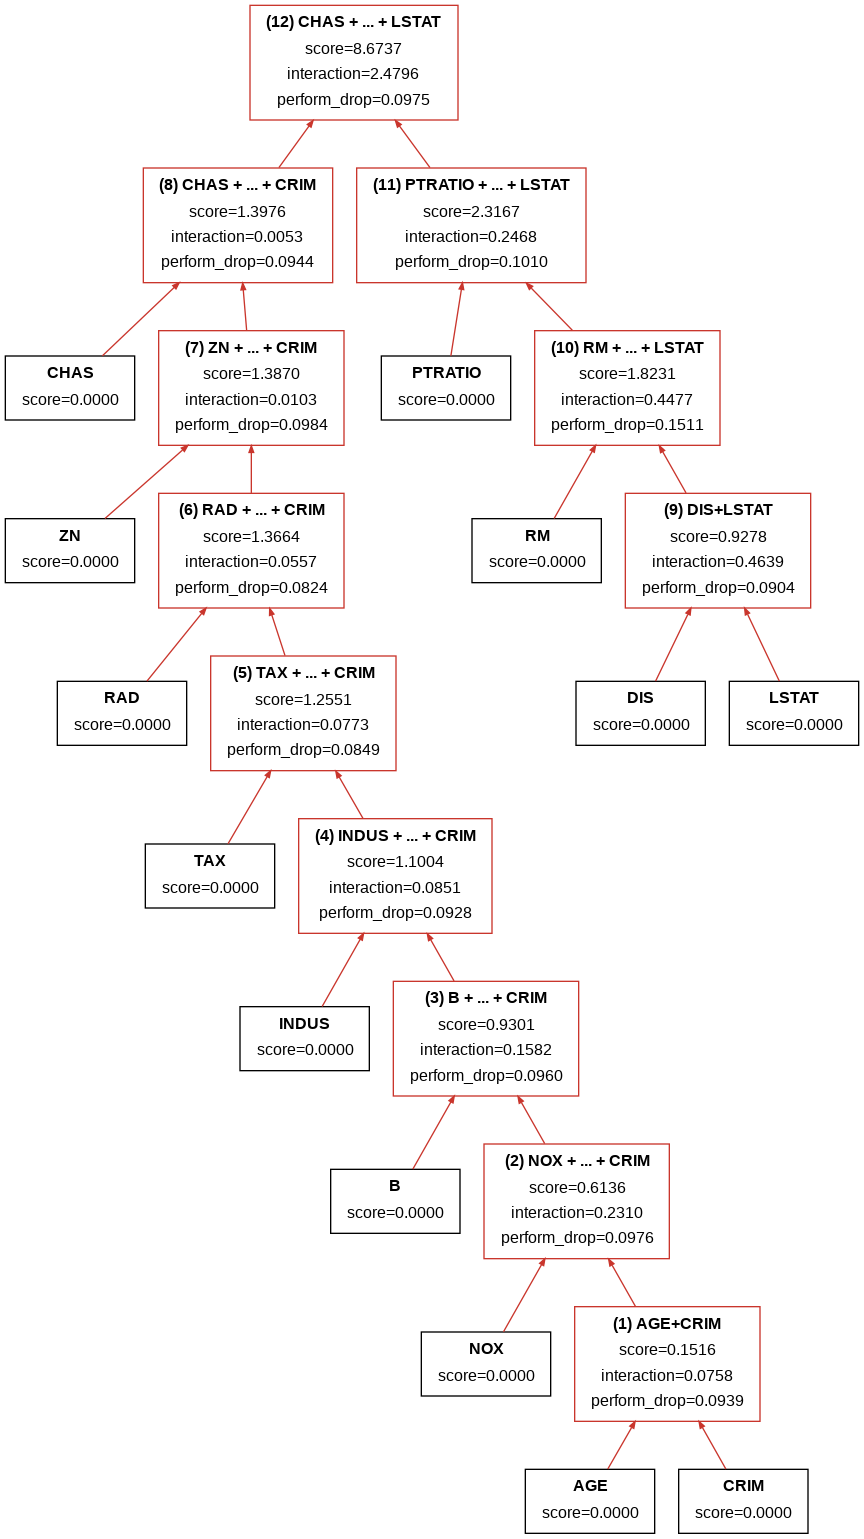

In [61]:
tree = tree_builder.build(
    score_method='abs_interaction', 
    shap_interactions=shap_interactions_g0, 
    n_select_scores=10,
    n_select_performance=5, 
    max_iter=None,
    initialize='random',
    filter_method='sort',
    rt_only_best=True
)
img = tree.show_tree(feature_names=dataset.feature_names)
display(img)

In [52]:
# get tree from group 3
group_id = 3
shap_interactions_g3 = tree_builder.shap_interaction_values(group_id=group_id)

Getting Interaction Values via SHAP package, might take a while...
Processing: # of data = 111, # of features = 13
Cost time: 0 mins 0.52 secs


<AxesSubplot:ylabel='Count'>

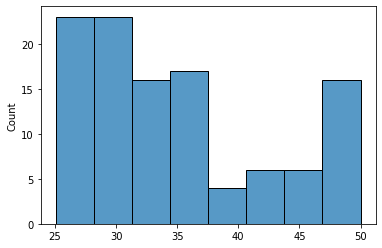

In [53]:
sns.histplot(dataset[group_id]['y_train'])

Building Tree: 100%|██████████| 13/13 [00:00<00:00, 22.15it/s, N keys to run: 1] 


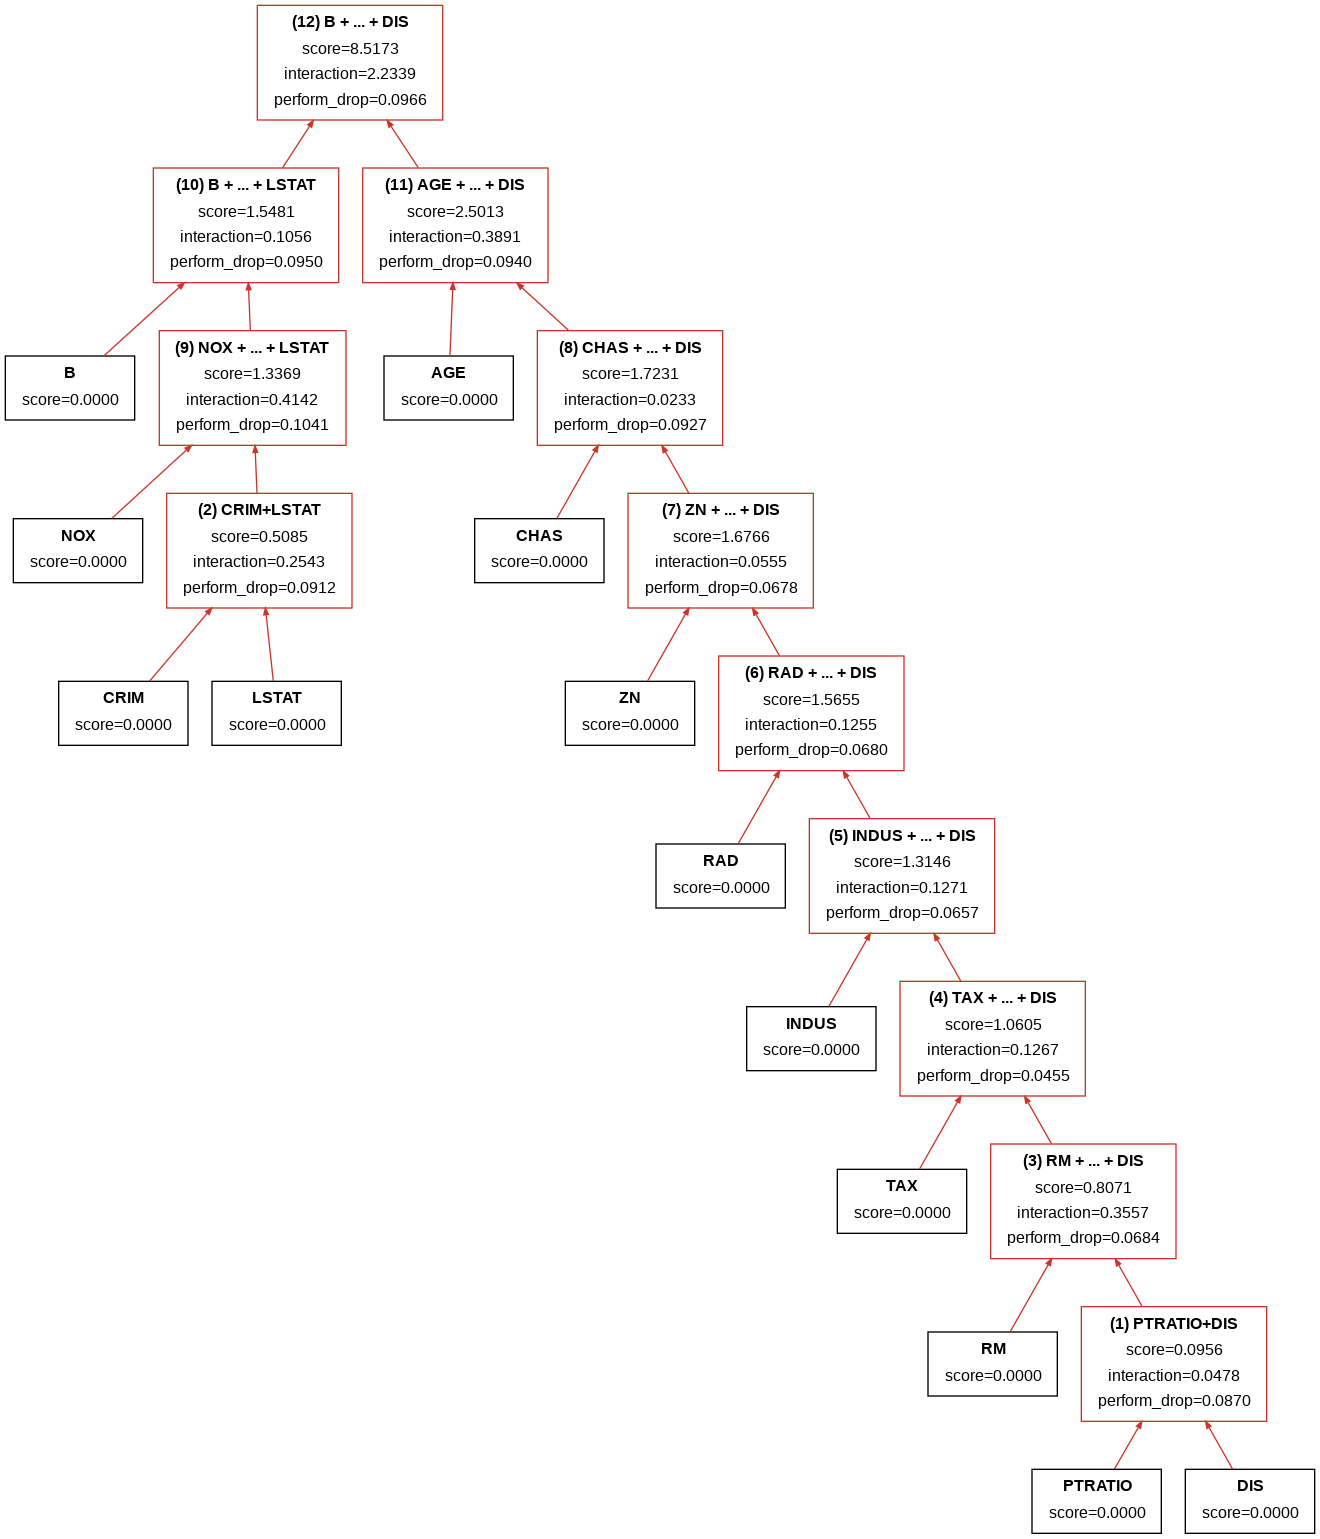

In [60]:
tree = tree_builder.build(
    score_method='abs_interaction', 
    shap_interactions=shap_interactions_g3, 
    n_select_scores=10,
    n_select_performance=5, 
    max_iter=None,
    initialize='random',
    filter_method='sort',
    rt_only_best=True
)
img = tree.show_tree(feature_names=dataset.feature_names)
display(img)

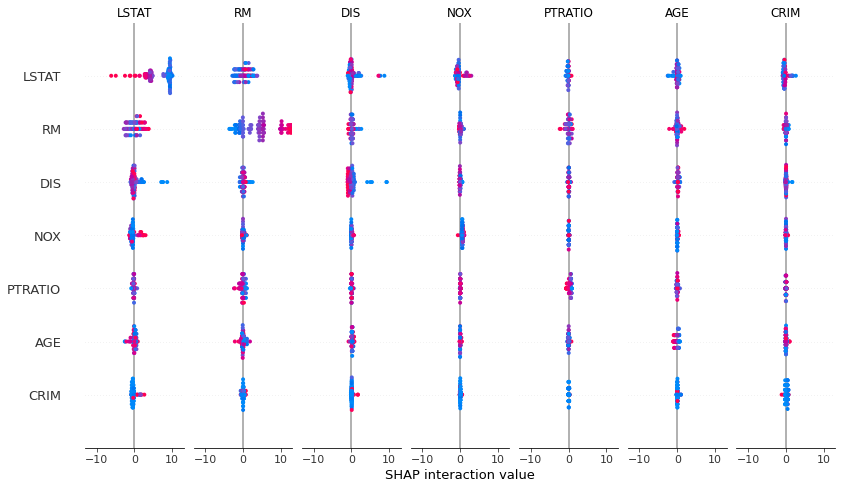

In [56]:
shap.summary_plot(shap_interactions_g3, dataset[3]['X_train'])

# Crime

In [39]:
seed = 8
dataset = Dataset(dataset_name='crime', data_folder='../data', seed=seed)
model_builder = ModelBuilder()
results = model_builder.train(dataset, eta=0.3, max_depth=8, subsample=1.0, seed=seed, num_rounds=400)

performance = results['score']
model = results['model']
print(f'test performance is {performance:.4f}')

tree_builder = TreeBuilder(model, dataset, original_score=performance)

[0]	test-rmse:644.63148
[80]	test-rmse:375.92180
[160]	test-rmse:375.87735
[240]	test-rmse:375.87709
[320]	test-rmse:375.87708
[399]	test-rmse:375.87708
test performance is 0.5860


In [40]:
# get tree from group 0
group_id = 0
shap_interactions = tree_builder.shap_interaction_values(group_id=group_id)

Getting Interaction Values via SHAP package, might take a while...
Processing: # of data = 453, # of features = 101
Cost time: 0 mins 30.57 secs


<AxesSubplot:ylabel='Count'>

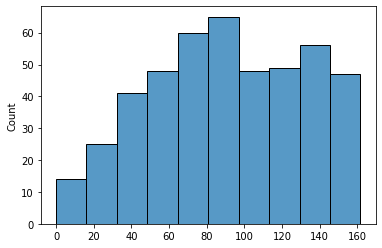

In [41]:
sns.histplot(dataset[group_id]['y_train'])

In [43]:
tree = tree_builder.build(
    score_method='abs', 
    shap_interactions=shap_interactions, 
    n_select_scores=5,
    n_select_performance=5, 
    max_iter=None,
    initialize=None,
    rt_only_best=True
)
img = tree.show_tree(feature_names=dataset.feature_names)
display(img)

Building Tree:  97%|█████████▋| 98/101 [01:23<00:02,  1.46it/s, N keys to run: 5]overflow encountered in square
overflow encountered in square
invalid value encountered in subtract
overflow encountered in square


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\simon\.virtualenvs\FinerGranularityExplanation-KRKjZpN0\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\simon\AppData\Local\Temp\ipykernel_27832\2513623548.py", line 1, in <cell line: 1>
    tree = tree_builder.build(
  File "c:\Users\simon\Desktop\Codes\FinerGranularityExplanation\fge\tree_builder.py", line 127, in build
    self.logger.close()
  File "c:\Users\simon\Desktop\Codes\FinerGranularityExplanation\fge\tree_builder.py", line 220, in _build
  File "c:\Users\simon\Desktop\Codes\FinerGranularityExplanation\fge\tree_builder.py", line 220, in _build
  File "c:\Users\simon\Desktop\Codes\FinerGranularityExplanation\fge\tree_builder.py", line 220, in _build
  [Previous line repeated 94 more times]
  File "c:\Users\simon\Desktop\Codes\FinerGranularityExplanation\fge\tree_builder.py", line 173, in _build
    heapq.heappush(performances,

In [50]:
len(list(tree_builder.infos[97]['nodes'][0].keys()))

4

# nhanesi

In [51]:
seed = 8
dataset = Dataset(dataset_name='nhanesi', data_folder='../data', seed=seed)
model_builder = ModelBuilder()
results = model_builder.train(dataset, eta=0.05, max_depth=8, subsample=1.0, seed=seed, num_rounds=400)

performance = results['score']
model = results['model']
print(f'test performance is {performance:.4f}')

tree_builder = TreeBuilder(model, dataset, original_score=performance)

[0]	test-cox-nloglik:6.90328
[80]	test-cox-nloglik:6.33167
[160]	test-cox-nloglik:6.34874
[240]	test-cox-nloglik:6.38151
[320]	test-cox-nloglik:6.41794
[399]	test-cox-nloglik:6.45491
test performance is 0.8009


In [68]:
from sklearn.preprocessing import PolynomialFeatures
import itertools
X_train, X_test = dataset.data['X_train'].copy(), dataset.data['X_test'].copy()
poly = PolynomialFeatures(2, interaction_only=True, include_bias=True)
X_train_full, X_test_full = poly.fit_transform(X_train), poly.fit_transform(X_test)

In [73]:
X_train.iloc[:, :3]

,sex_isFemale,age,physical_activity
1123,False,26,2
5124,True,30,4
3259,True,25,3
6158,True,36,4
14027,True,27,4
...,...,...,...
4002,True,66,4
19588,False,38,3
3727,True,69,2
17759,False,44,3


In [69]:
len(list(itertools.combinations(np.arange(X_train.shape[1]), 2)))

1431

In [74]:
X_train_full[:, :3]

array([[ 1.,  0., 26.],
       [ 1.,  1., 30.],
       [ 1.,  1., 25.],
       ...,
       [ 1.,  1., 69.],
       [ 1.,  0., 44.],
       [ 1.,  1., 45.]])

In [52]:
# get tree from group 0
group_id = 0
shap_interactions = tree_builder.shap_interaction_values(group_id=group_id)

Getting Interaction Values via SHAP package, might take a while...
Processing: # of data = 2979, # of features = 54
Cost time: 2 mins 3.85 secs


In [56]:
tree = tree_builder.build(
    score_method='abs', 
    shap_interactions=shap_interactions, 
    n_select_scores=5,
    n_select_performance=5, 
    max_iter=25,
    initialize='random',
    rt_only_best=True
)
img = tree.show_tree(feature_names=dataset.feature_names)
display(img)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\simon\.virtualenvs\FinerGranularityExplanation-KRKjZpN0\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\simon\AppData\Local\Temp\ipykernel_27832\536548854.py", line 1, in <cell line: 1>
    tree = tree_builder.build(
  File "c:\Users\simon\Desktop\Codes\FinerGranularityExplanation\fge\tree_builder.py", line 127, in build
    self.logger.close()
  File "c:\Users\simon\Desktop\Codes\FinerGranularityExplanation\fge\tree_builder.py", line 220, in _build
  File "c:\Users\simon\Desktop\Codes\FinerGranularityExplanation\fge\tree_builder.py", line 220, in _build
  File "c:\Users\simon\Desktop\Codes\FinerGranularityExplanation\fge\tree_builder.py", line 220, in _build
  [Previous line repeated 10 more times]
  File "c:\Users\simon\Desktop\Codes\FinerGranularityExplanation\fge\tree_builder.py", line 173, in _build
    heapq.heappush(performances, 

In [68]:
tree_builder.infos[1]['nodes_to_run'][0][25:]

[25,
 26,
 27,
 28,
 29,
 31,
 32,
 33,
 34,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 (35, 30)]

## Debug

In [8]:
from anytree import Node

In [9]:
tree_builder.reset_tree(False)
k=0
g_fn = tree_builder.score_methods['abs']
# feature settings

if shap_interactions.ndim == 3:
    # ndim == 3 case: global tree
    build_global = True
elif shap_interactions.ndim == 2:
    # ndim == 2 case: single tree
    build_global = False
else:
    raise ValueError('number of dimension of `shap_interactions` should be 2 or 3')

siv_scores = g_fn(shap_interactions, build_global)
max_iter = 10
r_diag, c_diag = np.diag_indices(len(tree_builder.feature_names))
main_effect = siv_scores[r_diag, c_diag]
tree_builder.infos[k]['nodes'] = [dict()]
tree_builder.infos[k]['done'] = [set()]
for i, name in enumerate(tree_builder.feature_names):
    tree_builder.infos[k]['nodes'][0][i] = Node(
        name=name, parent=None, score=main_effect[i], interaction=0.0, k=0, drop=0.0
    )

Building Tree:  60%|██████    | 6/10 [07:38<05:05, 76.34s/it]


---

# crime

In [28]:
# get tree from group 3
group_id = 3
shap_interactions = tree_builder.shap_interaction_values(group_id=group_id)
tree = tree_builder.build(
    score_method='abs', 
    shap_interactions=shap_interactions, 
    n_select=5,
    max_iter=None,
    rt_only_best=True
)
img = tree.show_tree(feature_names=dataset.feature_names)
display(img.resize((640, 680)))

(25,)

In [ ]:
tree_builder = TreeBuilder(
    task_type=model_builder.task_type, 
    original_score=performance, 
    dataset=dataset
)
trees = tree_builder.build(
    score_method='ratio', 
    shap_interactions=shap_interaction_values, 
    n_select=1,
    max_iter=30
)

In [ ]:
new_X_train, new_X_test = tree_builder.polyfitter.get_selected_X(tree_builder.infos[0]['nodes'][0], feature_names=tree_builder.feature_names)

In [ ]:
new_X_train.columns[new_X_train.isnull().sum(0) != 0]

In [ ]:
for key, tree in trees:
    print(key)
    display(tree.show_tree(feature_names=feature_names))